<a href="https://colab.research.google.com/github/gabrielycarrari/tcc/blob/pre-processing/pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook para Pré-processamento

# Importações

In [2]:
!pip install --upgrade tensorflow tensorflow-io


In [1]:
#!pip install tensorflow==2.11.0
!pip install tensorflow_io
import tensorflow_io as tfio

In [3]:
!pip install datasets
from datasets import load_dataset

In [ ]:
!pip install jiwer

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
from huggingface_hub import login
from google.colab import userdata


In [6]:
login(token=userdata.get('HUGGINGFACE_TOKEN'))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [7]:
# Carregar o dataset Common Voice 17
dataset = load_dataset("mozilla-foundation/common_voice_17_0", "pt", split='train', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# Carregar o dataset Common Voice 17
dataset_validation = load_dataset("mozilla-foundation/common_voice_17_0", "pt", split='validation', trust_remote_code=True)

In [9]:
print("GPUs disponíveis:", len(tf.config.list_physical_devices('GPU')))

GPUs disponíveis: 1


In [ ]:
dataset

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 9464
})

### Testes

In [ ]:
dataset[0]

{'client_id': 'df268ebd4060c8106179019a8bb331f8db173023c64d4e56a38a54f77f2fe6706480320965871d1b8d11da18601c241c8c4b80dc44d3ff9a32ee54991f5c0e99',
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/fe3a346df3c979ff3eb48fa107c50894678ab25af4c6f7785dec890ecdff72f7/pt_train_0/common_voice_pt_33954672.mp3',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/fe3a346df3c979ff3eb48fa107c50894678ab25af4c6f7785dec890ecdff72f7/pt_train_0/common_voice_pt_33954672.mp3',
  'array': array([ 1.77635684e-15, -5.41788836e-14, -9.05941988e-14, ...,
          1.72863140e-10,  1.45055787e-10,  7.10012743e-11]),
  'sampling_rate': 48000},
 'sentence': 'Sinta-se feliz com a vitória que você ganha.',
 'up_votes': 4,
 'down_votes': 0,
 'age': 'thirties',
 'gender': 'male_masculine',
 'accent': 'Minas Gerais',
 'locale': 'pt',
 'segment': '',
 'variant': 'Portuguese (Brasil)'}

In [ ]:
dataset[0]['sentence']

'Sinta-se feliz com a vitória que você ganha.'

In [ ]:
file = tf.io.read_file('/content/samples_pt_sample.wav')

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /content/samples_pt_sample.wav; No such file or directory [Op:ReadFile]

In [ ]:
import librosa
import tensorflow as tf
import soundfile as sf

# Load the audio file with librosa
audio_data, sample_rate = librosa.load('/content/samples_pt_sample.wav', sr=None)

# Resample to 16kHz (if necessary)
target_sample_rate = 16000
if sample_rate != target_sample_rate:
    audio_data = librosa.resample(audio_data, orig_sr=sample_rate, target_sr=target_sample_rate)

# Save the resampled audio as a WAV file
sf.write('resampled_audio.wav', audio_data, target_sample_rate)

# Load the resampled file using tensorflow
file = tf.io.read_file('resampled_audio.wav')
audio, _ = tf.audio.decode_wav(file)

In [ ]:
audio = tf.squeeze(audio, axis=-1)
# 3. Change type to float
audio = tf.cast(audio, tf.float32)

In [ ]:
audio

<tf.Tensor: shape=(74240,), dtype=float32, numpy=
array([2.2583008e-03, 2.4719238e-03, 1.5869141e-03, ..., 3.0517578e-05,
       9.1552734e-05, 9.1552734e-05], dtype=float32)>

In [ ]:
audio2 = dataset[0]['audio']['array']
sampling_rate = dataset[0]['audio']['sampling_rate']

# 2. Convert audio to a tensor
audio2 = tf.convert_to_tensor(audio2, dtype=tf.float32)

In [ ]:
dataset[0]['audio']['sampling_rate']

48000

In [ ]:
audio2

<tf.Tensor: shape=(195264,), dtype=float32, numpy=
array([ 1.7763568e-15, -5.4178884e-14, -9.0594199e-14, ...,
        1.7286314e-10,  1.4505579e-10,  7.1001274e-11], dtype=float32)>

### Definindo Caracteres

In [10]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyzáàâãéêíóôõúç'?!.- "]

# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'á', 'à', 'â', 'ã', 'é', 'ê', 'í', 'ó', 'ô', 'õ', 'ú', 'ç', "'", '?', '!', '.', '-', ' '] (size=45)


# Data Preprocessing

In [11]:
# The window length in samples.
frame_length = 256
# The number of samples to step.
frame_step = 160
# The size of the FFT to apply.
fft_length = 384

In [ ]:
file_ = tf.io.read_file(dataset[0]['path'])

In [ ]:
audio = tfio.audio.decode_mp3(file_)

In [ ]:
audio = tf.squeeze(audio, axis=-1)

In [ ]:
audio = tf.cast(audio, tf.float32)

In [ ]:
audio = tf.convert_to_tensor(audio, dtype=tf.float32)

In [ ]:
audio

<tf.Tensor: shape=(130176,), dtype=float32, numpy=
array([ 0.0000000e+00, -9.4646784e-14, -8.9593019e-14, ...,
        1.7161315e-10,  1.7143534e-10,  1.1382829e-10], dtype=float32)>

In [ ]:
dataset[0]['path']

'/root/.cache/huggingface/datasets/downloads/extracted/fe3a346df3c979ff3eb48fa107c50894678ab25af4c6f7785dec890ecdff72f7/pt_train_0/common_voice_pt_33954672.mp3'

In [12]:
def encode_single_sample(audio_path, label):
  ###########################################
  ##  Process the Audio
  ##########################################
  # 1. Read wav file
  file = tf.io.read_file(audio_path)
  # 2. Decode the wav file
  audio = tfio.audio.decode_mp3(file)
#  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis=-1)
  # 3. Change type to float
  audio = tf.cast(audio, tf.float32)

  # 2. Convert audio to a tensor
  audio = tf.convert_to_tensor(audio, dtype=tf.float32)

  # 4. Get the spectrogram
  spectrogram = tf.signal.stft(
      audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
  )
  # 5. We only need the magnitude, which can be derived by applying tf.abs
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
  # 6. normalisation
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)


  ###########################################
  ##  Process the label
  ##########################################
  # 7. Convert label to Lower case
  label = tf.strings.lower(label)
  # 8. Split the label
  label = tf.strings.unicode_split(label, input_encoding="UTF-8")
  # 9. Map the characters in label to numbers
  label = char_to_num(label)
  # 10. Return a dict as our model is expecting two inputs
  return spectrogram, label

In [13]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(dataset["path"]), list(dataset["sentence"]))
)

In [14]:
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [15]:
# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(dataset_validation["path"]), list(dataset_validation["sentence"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
spectrograms = []
labels = []

for data in tqdm(dataset, desc="Processando dados", unit="data"):
    audio = data['audio']['array']
    spectrogram, label = encode_single_sample(audio, data['sentence'])
    spectrograms.append(spectrogram)
    labels.append(label)

Processando dados: 100%|██████████| 21968/21968 [07:22<00:00, 49.66data/s]


In [ ]:
spectrogram, label = encode_single_sample(dataset[0]['audio']['array'], dataset[0]['sentence'])

In [ ]:
spectrogram

<tf.Tensor: shape=(1219, 193), dtype=float32, numpy=
array([[ 1.6657089 ,  1.7006105 ,  1.8479182 , ..., -0.82513076,
        -0.83893055, -0.829094  ],
       [ 1.999373  ,  1.7483722 ,  1.4855099 , ..., -0.81034017,
        -0.80858064, -0.8089801 ],
       [ 0.7909164 ,  0.95239437,  1.2188578 , ..., -0.80961126,
        -0.8095434 , -0.80952334],
       ...,
       [ 0.2551299 ,  0.8557077 ,  0.9137746 , ..., -0.86999285,
        -0.87001526, -0.8697995 ],
       [ 0.6691177 ,  0.6066629 ,  0.76785856, ..., -0.87769675,
        -0.8774716 , -0.8778401 ],
       [ 0.65872556,  0.49569604,  0.69298553, ..., -0.87480515,
        -0.88802457, -0.87769204]], dtype=float32)>

In [ ]:
label

<tf.Tensor: shape=(44,), dtype=int64, numpy=
array([19,  9, 14, 20,  1, 43, 19,  5, 44,  6,  5, 12,  9, 26, 44,  3, 15,
       13, 44,  1, 44, 22,  9, 20, 34, 18,  9,  1, 44, 17, 21,  5, 44, 22,
       15,  3, 32, 44,  7,  1, 14,  8,  1, 42])>

In [ ]:
# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(spectrograms, labels, test_size=0.1, random_state=42)

In [ ]:
batch_size = 32

In [ ]:
max_length = max(spec.shape[0] for spec in X_train)

In [ ]:
max_length

3369

In [ ]:
teste = X_train.padded_batch(batch_size)

AttributeError: 'list' object has no attribute 'padded_batch'

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(dataset['audio']['array'], dataset['sentence'], test_size=0.10, random_state=42)

In [ ]:
# Split the dataset into training and validation sets. 90/10.
split = int(len(dataset) * 0.90)
# df_train = metadata_df[:split]
df_val = dataset[split:]

# print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 12


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(dataset['audio']['array']), list(dataset['sentence']))
)

AttributeError: 'function' object has no attribute 'display'

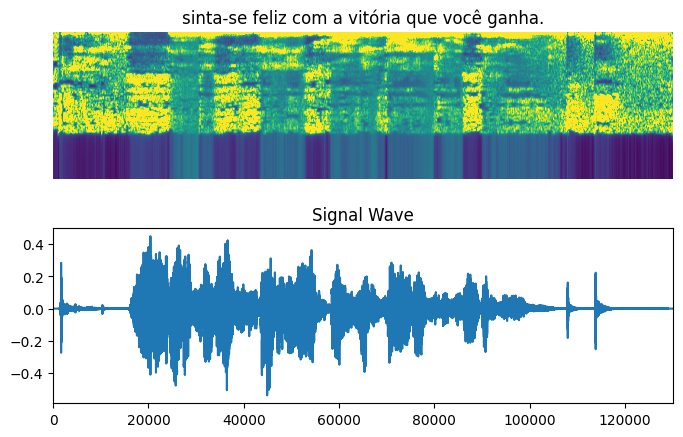

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(dataset[0]['path'])
    audio = tfio.audio.decode_mp3(file)
    #audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [16]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

## Define Model Architecture

In [17]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,642,830 (101.63 MB)

 Trainable params: 26,642,702 (101.63 MB)

 Non-trainable params: 128 (512.00 B)

In [18]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

## Model Training

In [20]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━

NameError: name 'wer' is not defined

## Salvando o Modelo

In [36]:
model.

<Functional name=DeepSpeech_2, built=True>

In [27]:
# Use the take() method to get the first element of the dataset
validation_dataset.take(2)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [29]:
from sklearn.metrics import accuracy_score

array([[[7.31191970e-03, 2.68105529e-02, 4.53345198e-03, ...,
         9.09733993e-04, 1.32398847e-02, 7.16451347e-01],
        [4.19621170e-03, 1.90942865e-02, 2.33858568e-03, ...,
         3.66348075e-04, 1.03618708e-02, 8.28842163e-01],
        [3.08445143e-03, 1.53663596e-02, 1.57377403e-03, ...,
         2.15990527e-04, 9.34281666e-03, 8.72625828e-01],
        ...,
        [1.60580873e-01, 1.05088766e-05, 4.84173961e-06, ...,
         1.63907600e-06, 1.04672381e-05, 8.39243889e-01],
        [1.78615168e-01, 2.15409691e-05, 1.13765664e-05, ...,
         4.24853033e-06, 2.40393056e-05, 8.20985913e-01],
        [2.18586773e-01, 9.52410992e-05, 6.01749671e-05, ...,
         2.69587636e-05, 1.18954791e-04, 7.79371381e-01]],

       [[7.30382325e-03, 2.67408472e-02, 4.80525056e-03, ...,
         9.61752376e-04, 1.40274810e-02, 7.08624840e-01],
        [4.21563443e-03, 1.91389546e-02, 2.50323932e-03, ...,
         3.90294823e-04, 1.11662783e-02, 8.23088706e-01],
        [3.09044472e-03, 

In [ ]:
predict = model.predict(validation_dataset)
accuracy = accuracy_score(validation_dataset.take(2), predict) * 100

296/296 ━━━━━━━━━━━━━━━━━━━━ 276s 932ms/step


In [ ]:
# Certifique-se de que a função wer está importada corretamente
from jiwer import wer

def evaluate_model(model, dataset):
    """Função para avaliar o modelo e calcular o Word Error Rate (WER)"""
    predictions = []
    targets = []

    # Faz a avaliação no dataset de validação
    for batch in dataset:
        X, y = batch
        # Gera previsões
        batch_predictions = model.predict(X)
        # Decodifica as previsões
        batch_predictions = decode_batch_predictions(batch_predictions)
        predictions.extend(batch_predictions)
        # Decodifica os rótulos verdadeiros
        for label in y:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            targets.append(label)

    # Calcula o WER
    wer_score = wer(targets, predictions)

    # Exibe o resultado
    print("-" * 100)
    print(f"Word Error Rate: {wer_score:.4f}")
    print("-" * 100)

    # Exibe algumas previsões e rótulos reais aleatórios
    for i in np.random.randint(0, len(predictions), 2):
        print(f"Target    : {targets[i]}")
        print(f"Prediction: {predictions[i]}")
        print("-" * 100)


In [ ]:
# Avalie o modelo no dataset de validação
evaluate_model(model, validation_dataset)


In [ ]:
validation_dataset

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
print("Saving Model")
path_model = '/content/drive/MyDrive/Model/'
model.save(path_model + 'model_v1.h5')


Saving Model


In [19]:
print("GPUs disponíveis:", len(tf.config.list_physical_devices('GPU')))

GPUs disponíveis: 1
